## Educational analytic case with McDonalds and Starbucks menu: what would be better as meals for teens?

[Case description] Restrictions from the task description [Restrictions, document-1 = link, document-2 = link]

DONE:
- values from norms (document-1) extracted manually --> txt --> dict. We find only 6 values: Energy(kcal), Fat(g), Carbohydrates(g), Fiber(g), Protein(g), Sodium (g), wich exist in all three datasets (document-1, McD and SB menus)
- values from McD and SB .csv menus --> Excel --> (processing: combine, add features in cols, enrichment)
- features added: (1) 'McD=0_SB=1': restraunt coding, (2) 'Category': food/drink, (3) 'Kind': bakery/breakfast/hot drink etc.
- dataset enriched manually: about 60 items in 'Snacks & sweets' category were added for SB menu. Thus we have more balanced dataaset (McD/SB share).
- discard from zeroes: dividing all mass values by 1000 (mg --> g)
- several bug fixes in values
- deleted items with all zeroes
- calculate weighted norms - according the rule requirement from official document-2
- deleting dishes with > 60% (breakfast + dinner) of day norm caloric or nutrition values (for instance, 1880 kcal (40 pieces of chicken McNuggets)

PLAN:
- include potential allergics - new feature?
- add the data on serving sizes
- search for nutrition indices or calculate integrated nutrition index (may be Carb:Fat:Prot matching those in norms?) and visualize it
- develop the decision making algorithm for combining potential breakfast and dinner sets 
- test the algorithm, corrections
- extract the results, preference for hot dishes and moderate-sugared drinks

In [530]:
# required imports
import pandas as pd
import numpy as np
from itertools import product, combinations
from matplotlib import pyplot as plt
%matplotlib inline

### Official norms

In [531]:
# Dict with actual norms (from official document-1)
norms = {}

f = open ('actual_norms.txt')

for line in f:
    line = line.strip().split(',')
    norms[line[0]] = line[1]
    
del norms['Item']
norms

{'Energy(kcal)': '2900',
 'Fat(g)': '97',
 'Carbohydrates(g)': '421',
 'Fiber(g)': '20',
 'Protein(g)': '87',
 'Sodium(g)': '1.3'}

In [532]:
# (From official document-2): 
# -breakfast + dinner = 20-25% + 30-35% daily energy value respectively --> 
# 25% and 35% (max due to sports competitions)
# -breakfast + dinner = 55-60% total daily nutrients value --> 
# 25% and 35% (max due to sports competitions)
# (only breakfast and dinner mentioned in the task)
# Let's assume that breakfast / dinner share are equal --> 
# meal_norm (30% and 30% respectively)

# calculating weighted norms:

meal_norm = {}

for key, value in norms.items():
    meal_norm[key] = float(value)*0.3
    
# sum_norm dict for data filtering (del items which contain greater values):   
sum_norm = {key:float(value)*0.6 for key, value in norms.items()}
    
print (meal_norm)
print (sum_norm)

{'Energy(kcal)': 870.0, 'Fat(g)': 29.099999999999998, 'Carbohydrates(g)': 126.3, 'Fiber(g)': 6.0, 'Protein(g)': 26.099999999999998, 'Sodium(g)': 0.39}
{'Energy(kcal)': 1740.0, 'Fat(g)': 58.199999999999996, 'Carbohydrates(g)': 252.6, 'Fiber(g)': 12.0, 'Protein(g)': 52.199999999999996, 'Sodium(g)': 0.78}


### McD & SB menus

In [533]:
# Starbucks (SB) and McDonalds (McD) combined menu in single df: 
menu_df = pd.read_csv ('combined_menu_300919.csv', sep=';', encoding = 'koi8-r')
menu_df.head()

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
0,1,food,Bakery,Chonga Bagel,300,5.0,50,3.0,12,0.53
1,1,food,Bakery,8-Grain Roll,380,6.0,70,7.0,10,0.43
2,1,food,Bakery,Almond Croissant,410,22.0,45,3.0,10,0.39
3,1,food,Bakery,Banana Nut Bread,420,22.0,52,2.0,6,0.32
4,1,food,Bakery,Birthday Cake Pop,170,9.0,23,0.0,1,0.11


In [534]:
# checking data gaps - it's OK
menu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
McD=0_SB=1          500 non-null int64
Category            500 non-null object
Kind                500 non-null object
Item                500 non-null object
Energy(kcal)        500 non-null int64
Fat(g)              500 non-null float64
Carbohydrates(g)    500 non-null int64
Fiber(g)            500 non-null float64
Protein(g)          500 non-null int64
Sodium(g)           500 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 39.1+ KB


### Clean the data

In [535]:
# any all-zero items to delete?
del_list = []
def find_zeroes (row):
    '''the function recieve row of a df and process it: if all quantitative fields 
    are zeroes in the row, the row included in list for deleting'''
    if row[4:].sum() == 0:
#         print (row)
        del_list.append (row[3])
        
menu_df.apply (find_zeroes, axis = 1)
menu_df = menu_df.loc[~menu_df['Item'].isin(del_list)]
len (menu_df) # 7 values deleted

493

In [536]:
# filtering: del items which contain values greater than weighted norm in sum_norm dict:

menu_df[menu_df['Energy(kcal)']>=sum_norm['Energy(kcal)']]
# only 1 item exceeds sum_norms (1740 kcal)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
322,0,food,Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.6


In [537]:
menu_df[menu_df['Fat(g)']>=sum_norm['Fat(g)']]
# 3 items exceed sum_norms (58.2 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
272,0,food,Hot Big Breakfast,BB with Hotcakes (Large Biscuit),1150,60.0,116,7.0,36,2.26
321,0,food,Burgers,Chicken McNuggets (20 piece),940,59.0,59,3.0,44,1.80
322,0,food,Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.60


In [538]:
menu_df[menu_df['Carbohydrates(g)']>=sum_norm['Carbohydrates(g)']]
# no items exceed sum_norms

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)


In [539]:
menu_df[menu_df['Fiber(g)']>=sum_norm['Fiber(g)']]
# 2 items exceed sum_norms (12.0 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
56,1,food,Protein Boxes & Bowls,Lentils & Vegetable Protein Bowl with Brown Rice,650,29.0,80,21.0,23,0.67
114,1,food,Fruit & Nuts,Bare Fruit Medley,130,0.0,31,24.0,1,0.00


In [540]:
menu_df[menu_df['Protein(g)']>=sum_norm['Protein(g)']]
# only 1 item exceeds sum_norms (52.2 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
322,0,food,Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.6


In [541]:
menu_df[menu_df['Sodium(g)']>=sum_norm['Sodium(g)']]
# Wow! 104 items exceed sum_norms (0.78 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
36,1,food,Cold Sandwiches,Chicken & Fig Spread,460,13.0,61,5.0,24,0.94
37,1,food,Cold Sandwiches,Chipotle Chicken Wrap,470,19.0,55,4.0,22,1.05
38,1,food,Protein Boxes & Bowls,Farmers' Market Protein Box,470,29.0,29,4.0,21,0.88
40,1,food,Warm Sandwiches,Grilled Chicken & Cauliflower Tabbouleh,390,27.0,15,4.0,21,1.14
41,1,food,Warm Sandwiches,Honey BBQ Sriracha Chicken Sandwich,360,7.0,52,3.0,22,1.09
43,1,food,Cold Sandwiches,Roasted Turkey & Dill Havarti Sandwich,600,32.0,47,6.0,32,0.86
44,1,food,Warm Sandwiches,Seasoned Turkey & Green Pepper Pico,390,18.0,30,5.0,28,0.90
45,1,food,Warm Sandwiches,Smoked Mozzarella & Roasted Pepper Sandwich,500,28.0,46,4.0,18,1.19
46,1,food,Warm Sandwiches,Smoked Pork Cubano,450,25.0,66,5.0,21,1.20
48,1,food,Warm Sandwiches,Turkey Pastrami Reuben,500,21.0,50,4.0,26,1.13


In [542]:
# Well, lets assume that salt needs increases due to sports: 1.0 g sodium threshold:
menu_df[menu_df['Sodium(g)']>=1]
# Nevertheless 73 items exceed 1.0 g

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
37,1,food,Cold Sandwiches,Chipotle Chicken Wrap,470,19.0,55,4.0,22,1.05
40,1,food,Warm Sandwiches,Grilled Chicken & Cauliflower Tabbouleh,390,27.0,15,4.0,21,1.14
41,1,food,Warm Sandwiches,Honey BBQ Sriracha Chicken Sandwich,360,7.0,52,3.0,22,1.09
45,1,food,Warm Sandwiches,Smoked Mozzarella & Roasted Pepper Sandwich,500,28.0,46,4.0,18,1.19
46,1,food,Warm Sandwiches,Smoked Pork Cubano,450,25.0,66,5.0,21,1.20
48,1,food,Warm Sandwiches,Turkey Pastrami Reuben,500,21.0,50,4.0,26,1.13
51,1,food,Protein Boxes & Bowls,Chicken & Quinoa Protein Bowl with Black Beans...,420,17.0,42,9.0,27,1.03
52,1,food,Protein Boxes & Bowls,Chicken BLT Protein Box,580,23.0,58,7.0,35,1.66
53,1,food,Protein Boxes & Bowls,Chicken Wrap Protein Box,460,22.0,45,4.0,20,1.00
58,1,food,Protein Boxes & Bowls,Smoked Turkey Protein Box,360,12.0,42,5.0,24,1.62


In [543]:
# Let's drop out all items that exceeds the criteria:
menu_df = menu_df[menu_df['Energy(kcal)'] < sum_norm['Energy(kcal)']]
menu_df = menu_df[menu_df['Fat(g)'] < sum_norm['Fat(g)']]
menu_df = menu_df[menu_df['Fiber(g)'] < sum_norm['Fiber(g)']]
menu_df = menu_df[menu_df['Protein(g)'] < sum_norm['Protein(g)']]
menu_df = menu_df[menu_df['Sodium(g)'] < 1.0]

len (menu_df)

418

In [544]:
# We increased the sodium sum norm 0.78 --> 1.0, i.e. +0.22. 
# In turns it increases sodium mealnorm by 0.11 g. Dicts update: 
meal_norm['Sodium(g)'] += 0.11
sum_norm['Sodium(g)'] += 0.22
print (meal_norm)
print (sum_norm)

{'Energy(kcal)': 870.0, 'Fat(g)': 29.099999999999998, 'Carbohydrates(g)': 126.3, 'Fiber(g)': 6.0, 'Protein(g)': 26.099999999999998, 'Sodium(g)': 0.5}
{'Energy(kcal)': 1740.0, 'Fat(g)': 58.199999999999996, 'Carbohydrates(g)': 252.6, 'Fiber(g)': 12.0, 'Protein(g)': 52.199999999999996, 'Sodium(g)': 1.0}


### Visualizations

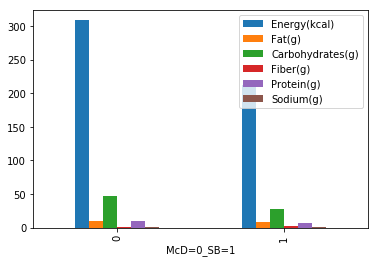

In [545]:
# all means for McD and SB menu
means = menu_df.groupby ('McD=0_SB=1').mean()
means.plot(kind = 'bar')

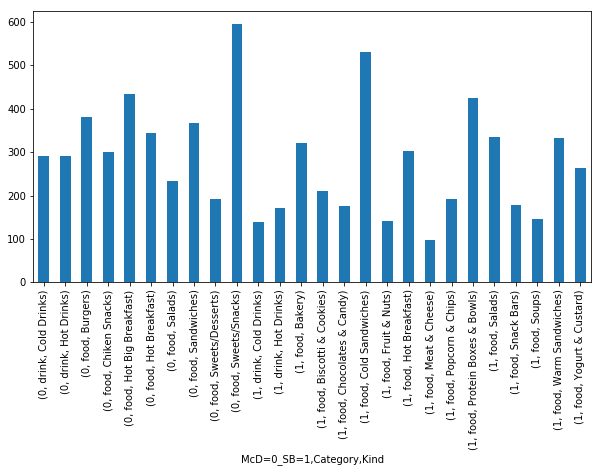

In [546]:
# All mean caloric values:
means_all = menu_df.groupby (['McD=0_SB=1', 'Category', 'Kind']).mean()
means_all['Energy(kcal)'].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.5, figsize = (10,5))

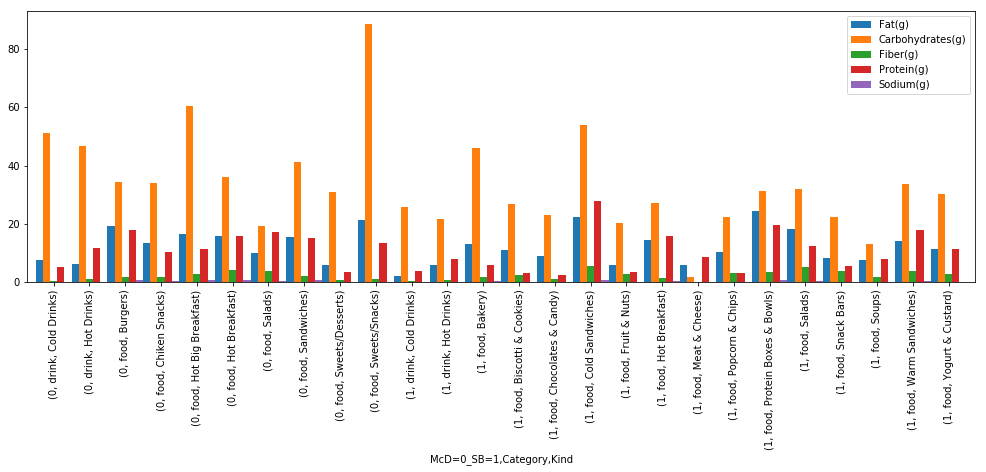

In [547]:
# All mean nutrition values:
means_all[['Fat(g)', 
          'Carbohydrates(g)', 
          'Fiber(g)', 
          'Protein(g)', 
          'Sodium(g)']].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 1, figsize = (17,5))

### Idea for core algorithm for menu making 
1. Normalize values of all items by dividing them on meal_norm values dict. <b>[DONE]</b>
2. Develop the format of breakfast / dinner (for instance, [1-st food item, 2-nd food item, 3-rd drink item]) <b>[DONE]</b>
3. Build a meal-maker function (dataset, format) which returns a result_dataset of combitations of items from dataset categories specified in format template <b>[DONE]</b>
4. Build an quality assement function, which recieves result_dataset and evaluate caloric and nutrition: 6 total values derived from all items in certain meal combitation and returns 'B-index' (Balance index): how that combination fits the norms. If 'B-index' close to 0 (StDev of six values that normalized as share of 1, noted above in p.1) the meal combination well fitted <b>[DONE]</b>
5. Evaluation of SB VS McD menus by this algorithm and draw the conclusions

In [548]:
# normalizing whole dataset for meal_norm --> new features:
for item in menu_df[['Energy(kcal)','Fat(g)', 'Carbohydrates(g)','Fiber(g)', 'Protein(g)', 'Sodium(g)']]:
    for key in meal_norm:
        if key == item:
            menu_df['n_'+item] = menu_df[item] / float (meal_norm[key])

menu_df
# menu_df.to_csv('menu_normalized.csv')

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g),n_Energy(kcal),n_Fat(g),n_Carbohydrates(g),n_Fiber(g),n_Protein(g),n_Sodium(g)
0,1,food,Bakery,Chonga Bagel,300,5.0,50,3.0,12,0.530,0.344828,0.171821,0.395883,0.500000,0.459770,1.06
1,1,food,Bakery,8-Grain Roll,380,6.0,70,7.0,10,0.430,0.436782,0.206186,0.554236,1.166667,0.383142,0.86
2,1,food,Bakery,Almond Croissant,410,22.0,45,3.0,10,0.390,0.471264,0.756014,0.356295,0.500000,0.383142,0.78
3,1,food,Bakery,Banana Nut Bread,420,22.0,52,2.0,6,0.320,0.482759,0.756014,0.411718,0.333333,0.229885,0.64
4,1,food,Bakery,Birthday Cake Pop,170,9.0,23,0.0,1,0.110,0.195402,0.309278,0.182106,0.000000,0.038314,0.22
5,1,food,Bakery,Blueberry Muffin,360,15.0,52,1.0,5,0.270,0.413793,0.515464,0.411718,0.166667,0.191571,0.54
6,1,food,Bakery,Blueberry Oat Cake,390,12.0,71,7.0,7,0.430,0.448276,0.412371,0.562154,1.166667,0.268199,0.86
7,1,food,Bakery,Blueberry Scone,420,17.0,61,2.0,5,0.350,0.482759,0.584192,0.482977,0.333333,0.191571,0.70
8,1,food,Bakery,Butter Croissant,240,12.0,28,1.0,5,0.320,0.275862,0.412371,0.221694,0.166667,0.191571,0.64
9,1,food,Bakery,Cheese Danish,320,16.0,36,1.0,8,0.400,0.367816,0.549828,0.285036,0.166667,0.306513,0.80


In [549]:
# how many items of McD / SB remains:
menu_df.groupby(by=['McD=0_SB=1']).count()

,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g),n_Energy(kcal),n_Fat(g),n_Carbohydrates(g),n_Fiber(g),n_Protein(g),n_Sodium(g)
McD=0_SB=1,,,,,,,,,,,,,,,
0,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201
1,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217


In [550]:
# splitting data to two subsets, reindexing:
SB_menu = menu_df.iloc[0:217]
SB_menu.drop(['McD=0_SB=1', 'Energy(kcal)', 'Fat(g)', 'Carbohydrates(g)', 'Fiber(g)', 'Protein(g)', 'Sodium(g)'], axis=1, inplace=True)
SB_menu.reset_index(drop=True, inplace=True)
McD_menu = menu_df.iloc[217:]
McD_menu.drop(['McD=0_SB=1', 'Energy(kcal)', 'Fat(g)', 'Carbohydrates(g)', 'Fiber(g)', 'Protein(g)', 'Sodium(g)'], axis=1, inplace=True)
McD_menu.reset_index(drop=True, inplace=True)

In [551]:
McD_menu['Kind'].unique()

array(['Hot Breakfast', 'Hot Big Breakfast', 'Sandwiches', 'Burgers',
       'Salads', 'Chiken Snacks', 'Sweets/Desserts', 'Sweets/Snacks',
       'Cold Drinks', 'Hot Drinks'], dtype=object)

In [552]:
SB_menu['Kind'].unique()

array(['Bakery', 'Salads', 'Cold Sandwiches', 'Protein Boxes & Bowls',
       'Warm Sandwiches', 'Yogurt & Custard', 'Soups', 'Hot Breakfast',
       'Biscotti & Cookies', 'Chocolates & Candy', 'Fruit & Nuts',
       'Popcorn & Chips', 'Meat & Cheese', 'Snack Bars', 'Cold Drinks',
       'Hot Drinks'], dtype=object)

In [553]:
## for SB menu-based let's assume menus following kinds. The groups could be
## combined to obtain from 2 to 5-positional meal. Lists of item groups:
SB_first = ['Soups', 'Salads', 'Protein Boxes & Bowls', 'Hot Breakfast']
SB_second = ['Bakery', 'Cold Sandwiches', 'Warm Sandwiches']
SB_desserts = ['Chocolates & Candy', 'Fruit & Nuts', 'Biscotti & Cookies', 'Yogurt & Custard']
SB_snacks = ['Meat & Cheese', 'Snack Bars', 'Fruit & Nuts', 'Popcorn & Chips']
SB_drinks = ['Cold Drinks', 'Hot Drinks']

## Sets of SB groups for combinations:

# a set for 3-item 'solid breakfast' as example
SB_solid_b = [SB_first, SB_second, SB_drinks] 

# a set for 2-item 'light breakfast':
SB_light_b = [SB_first, SB_drinks]

# a set for 3-item 'solid dinner':
SB_solid_d = [SB_second, SB_desserts, SB_drinks]

# a set for 2-item 'light dinner':
SB_light_d = [SB_second, SB_drinks]

# a set for 2-item 'snack breakfast/dinner':
SB_snack = [SB_snacks, SB_drinks]


SB_current = list(product(*SB_snack))
# SB_current

In [719]:
## for McD menu-based let's assume menus following kinds. The groups could be
## combined to obtain from 2 to 5-positional meal. Lists of item groups:
McD_first = ['Salads', 'Chiken Snacks']
McD_second = ['Hot Big Breakfast', 'Hot Breakfast', 'Sandwiches', 'Burgers']
McD_desserts = ['Sweets/Desserts', 'Sweets/Snacks']
McD_snacks = ['Chiken Snacks', 'Snacks']
McD_drinks = ['Cold Drinks', 'Hot Drinks']

# Sets of McD groups for combinations:

# a set for 3-item 'solid breakfast' as example
McD_solid_b = [McD_second, McD_drinks] 

# a set for 2-item 'light breakfast':
McD_light_b = [McD_first, McD_drinks]

# a set for 3-item 'solid dinner':
McD_solid_d = [McD_snacks, McD_desserts, McD_drinks]

# a set for 2-item 'light dinner':
McD_light_d = [McD_first, McD_snacks, McD_drinks]

# a set for 2-item 'snack breakfast/dinner':
McD_snack = [McD_snacks, McD_drinks]


McD_current = list(product(*McD_light_d))
# McD_current

[('Salads', 'Chiken Snacks', 'Cold Drinks'),
 ('Salads', 'Chiken Snacks', 'Hot Drinks'),
 ('Salads', 'Snacks', 'Cold Drinks'),
 ('Salads', 'Snacks', 'Hot Drinks'),
 ('Chiken Snacks', 'Chiken Snacks', 'Cold Drinks'),
 ('Chiken Snacks', 'Chiken Snacks', 'Hot Drinks'),
 ('Chiken Snacks', 'Snacks', 'Cold Drinks'),
 ('Chiken Snacks', 'Snacks', 'Hot Drinks')]

In [720]:
# # saving the current list of combinations:
# with open("McD_light_d_8.txt", "w") as file:
#     for item in McD_current:
#          print(item, file=file, sep="\n")
#     file.close ()

In [769]:
# Let's design the breakfast / dinner formats ('kinds') from above catrgories.

k1, k2, k3 = [], [], []

kinds = McD_current[8]

def kind_lists (row, args=kinds):
    
    '''making lists of all items that matches with respective kind in 'kinds' format
    3 kind-format --> 3 lists of items'''

    if kinds[0] in row[1]:
        k1.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # Well, not so
    if kinds[1] in row[1]:
        k2.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # elegant code...
    if kinds[2] in row[1]:
        k3.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # slices --> kernel dies
    
    return k1,k2,k3

McD_menu.apply (kind_lists, axis=1)

# make all non-repeated element-wise combinations of items (by default of 3 items = len (kinds))
arrs = [k1,k2,k3]
combinator = list(product(*arrs))
df_combi = pd.DataFrame (combinator)
# df_combi.head()

IndexError: list index out of range

In [764]:
len (df_combi)

9360

In [765]:
# Let's evaluate all these combinations by their B-index. 
# (possibly it could be designed with more pythonic and elegant code =)

'''df-applied functions calculate inversions of weighted sums. Next is calculating 
    of B-index as mean of weighted (described above) values in row of elements 
    representing a cetrain meal variant. Returns same df featured by 6 inversed
    weighted sums and B_index column. ZeroDivisionError catched --> value setted to 0.
    
    So the more B_index equal to 1, the more balanced items combination we found.
    If 'B-index' close to 1 (mean of six inv. values that normalized (weighted ) 
    as share of 1, noted above in p.1) then meal combination well fitted.'''

def e_sum (row):
    
    e_sum = row[0][1] + row[1][1] + row[2][1]
    try:
        return 1/e_sum
        
    except ZeroDivisionError:
        return 0
    
def f_sum (row):   
    
    f_sum = row[0][2] + row[1][2] + row[2][2]
    try:
        return 1/f_sum
        
    except ZeroDivisionError:
        return 0
    
def c_sum (row):       
    
    c_sum = row[0][3] + row[1][3] + row[2][3]
    try:
        return 1/c_sum
        
    except ZeroDivisionError:
        return 0
    
def fi_sum (row):
    
    fi_sum = row[0][4] + row[1][4] + row[2][4]
    
    try:
        return 1/fi_sum
    
    except ZeroDivisionError:
        return 0
    
def p_sum (row): 
    
    p_sum = row[0][5] + row[1][5] + row[2][5]
    try:
        return 1/p_sum
    
    except ZeroDivisionError:
        return 0
    
def s_sum (row):

    s_sum = row[0][6] + row[1][6] + row[2][6]
    try:
        return 1/s_sum
    
    except ZeroDivisionError:
        return 0

In [766]:
# inversed weighted sums for each estimated value for control:
# values < 1 --> norm not reached, 
# values > 1 --> norm exceeded,
# values ≈ 1 --> best fitted to norms
df_combi['Energy'] = df_combi.apply (e_sum, axis=1)
df_combi['Fat'] = df_combi.apply (f_sum, axis=1)
df_combi['Carbohydrates'] = df_combi.apply (c_sum, axis=1)
df_combi['Fiber'] = df_combi.apply (fi_sum, axis=1)
df_combi['Protein'] = df_combi.apply (p_sum, axis=1)
df_combi['Sodium'] = df_combi.apply (s_sum, axis=1)

# finally, B-index: mean of inversed weighted sums:
df_combi['B_index'] = df_combi.iloc[:,3:].mean(axis=1)
# df_combi

In [767]:
# df for comparisons:
# prefixes means restraunt name (McD/SB), kind of meal (breakfast/dinner == 'b' or 'd')
# and version of subset
index_df = pd.DataFrame (df_combi['B_index'])
index_df.rename(columns={'B_index': 'McD_light_d_0'}, inplace=True)
# index_df['McD_light_d_7'] = df_combi['B_index']
index_df.head()

,McD_light_d_0,McD_light_d_1,McD_light_d_2,McD_light_d_3,McD_light_d_4,McD_light_d_5,McD_light_d_6,McD_light_d_7
0,1.215384,1.211930,1.215384,1.211930,1.233555,1.230808,1.233555,1.230808
1,1.155998,1.176658,1.155998,1.176658,1.198223,1.210241,1.198223,1.210241
2,1.098318,1.143716,1.098318,1.143716,1.161647,1.190309,1.161647,1.190309
3,1.267412,1.266612,1.267412,1.266612,1.262713,1.262232,1.262713,1.262232
4,1.485993,1.124717,1.485993,1.124717,1.367797,1.032116,1.367797,1.032116


In [770]:
# index_df.to_csv('McD_light_d_8.csv', index=False)